In [ ]:

#!pip install pyarrow pandas matplotlib seaborn

# Data Exploration - Market Data

This notebook explores the ingested market data from `data/raw.market` and `data/curated.market`.

**Objectives:**
1. Load and inspect Parquet files
2. Check data quality (nulls, date ranges, coverage)
3. Visualize key time series (SPY, VIX, returns)
4. Compute basic statistics

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set project root
project_root = Path.cwd()
while project_root.name != 'volatility_forecast' and project_root.parent != project_root:
    project_root = project_root.parent

print(f"Project root: {project_root}")

%matplotlib inline

Project root: /Users/aayushrijal/Documents/GitHub/volatility_forecast


## 1. Reading Parquet Files

There are two ways to read the Parquet files:

1. **Read a single partition** (one date)
2. **Read all partitions** (all dates)

In [21]:
# Read a single Parquet file (one date)
raw_path = project_root / "data/raw.market"
parquet_files = sorted(list(raw_path.glob("date=*/raw.market.parquet")))

if parquet_files:
    sample_file = parquet_files[-1]  # Most recent date
    print(f"Reading: {sample_file.parent.name}/{sample_file.name}")
    
    df_sample = pd.read_parquet(sample_file)
    print(f"Shape: {df_sample.shape}")
    print(f"Columns: {df_sample.columns.tolist()}\n")
    print(df_sample.head())
else:
    print(f"No data found in {raw_path}")

Reading: date=2025-12-02/raw.market.parquet
Shape: (4, 7)
Columns: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']

   symbol       date        open        high         low       close   
0     SPY 2025-12-02  681.919983  683.820007  679.327515  682.359985  \
1    ^VIX 2025-12-02   17.280001   17.309999   16.389999   16.570000   
2  ^VIX3M 2025-12-02   20.000000   20.250000   19.730000   19.809999   
3     HYG 2025-12-02   80.540001   80.639999   80.474998   80.620003   

       volume  
0  43146657.0  
1         0.0  
2         0.0  
3  31439535.0  


In [22]:
# Read all partitions (all dates)
raw_path = project_root / "data/raw.market"
raw_files = list(raw_path.glob("date=*/raw.market.parquet"))
print(f"Found {len(raw_files)} raw partitions")

raw_df = pd.concat([pd.read_parquet(f) for f in raw_files], ignore_index=True)
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.sort_values(['symbol', 'date']).reset_index(drop=True)

print(f"Shape: {raw_df.shape}")
print(f"Date range: {raw_df['date'].min().date()} to {raw_df['date'].max().date()}")
print(f"Symbols: {raw_df['symbol'].unique().tolist()}\n")
raw_df.head(10)

Found 4004 raw partitions
Shape: (20019, 7)
Date range: 2010-01-04 to 2025-12-02
Symbols: ['HYG', 'SPY', 'TLT', '^VIX', '^VIX3M']



,symbol,date,open,high,low,close,volume
0,HYG,2010-01-04,88.000000,88.529999,88.000000,88.529999,1316800.0
1,HYG,2010-01-05,88.750000,89.080002,88.419998,88.949997,733000.0
2,HYG,2010-01-06,89.040001,89.260002,89.000000,89.180000,715700.0
3,HYG,2010-01-07,89.379997,89.629997,89.110001,89.540001,956000.0
4,HYG,2010-01-08,89.559998,89.809998,89.510002,89.680000,711400.0
5,HYG,2010-01-11,89.500000,89.709999,89.480003,89.599998,895800.0
6,HYG,2010-01-12,89.500000,90.290001,89.050003,89.139999,1133900.0
7,HYG,2010-01-13,89.099998,89.419998,89.099998,89.339996,868900.0
8,HYG,2010-01-14,89.440002,89.480003,89.209999,89.440002,394600.0
9,HYG,2010-01-15,89.519997,89.519997,88.989998,89.080002,835300.0


In [23]:
# Read curated data with daily returns
curated_path = project_root / "data/curated.market"
curated_files = list(curated_path.glob("date=*/daily.parquet"))
print(f"Found {len(curated_files)} curated partitions")

curated_df = pd.concat([pd.read_parquet(f) for f in curated_files], ignore_index=True)
curated_df['date'] = pd.to_datetime(curated_df['date'])
curated_df = curated_df.sort_values(['symbol', 'date']).reset_index(drop=True)

print(f"Shape: {curated_df.shape}")
print(f"Date range: {curated_df['date'].min().date()} to {curated_df['date'].max().date()}\n")
curated_df.head(10)

Found 4004 curated partitions
Shape: (20019, 5)
Date range: 2010-01-04 to 2025-12-02



,symbol,date,close,adj_close,ret
0,HYG,2010-01-04,88.529999,35.435684,NaN
1,HYG,2010-01-05,88.949997,35.603798,0.004733
2,HYG,2010-01-06,89.180000,35.695858,0.002582
3,HYG,2010-01-07,89.540001,35.839951,0.004029
4,HYG,2010-01-08,89.680000,35.895973,0.001562
5,HYG,2010-01-11,89.599998,35.863995,-0.000891
6,HYG,2010-01-12,89.139999,35.679832,-0.005148
7,HYG,2010-01-13,89.339996,35.759899,0.002242
8,HYG,2010-01-14,89.440002,35.799942,0.001119
9,HYG,2010-01-15,89.080002,35.655811,-0.004034


## 2. Data Quality Checks

In [24]:
# Check for missing values
print("Raw data - Missing values:")
print(raw_df.isnull().sum())
print("\n" + "="*40 + "\n")
print("Curated data - Missing values:")
print(curated_df.isnull().sum())

Raw data - Missing values:
symbol    0
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


Curated data - Missing values:
symbol       0
date         0
close        0
adj_close    0
ret          5
dtype: int64


In [25]:
# Check data coverage per symbol
coverage = raw_df.groupby('symbol')['date'].agg(['min', 'max', 'count'])
coverage.columns = ['Start Date', 'End Date', 'Trading Days']
coverage

,Start Date,End Date,Trading Days
symbol,,,
HYG,2010-01-04,2025-12-02,4004
SPY,2010-01-04,2025-12-02,4004
TLT,2010-01-04,2025-12-01,4003
^VIX,2010-01-04,2025-12-02,4004
^VIX3M,2010-01-04,2025-12-02,4004


## 3. Quick Visualization

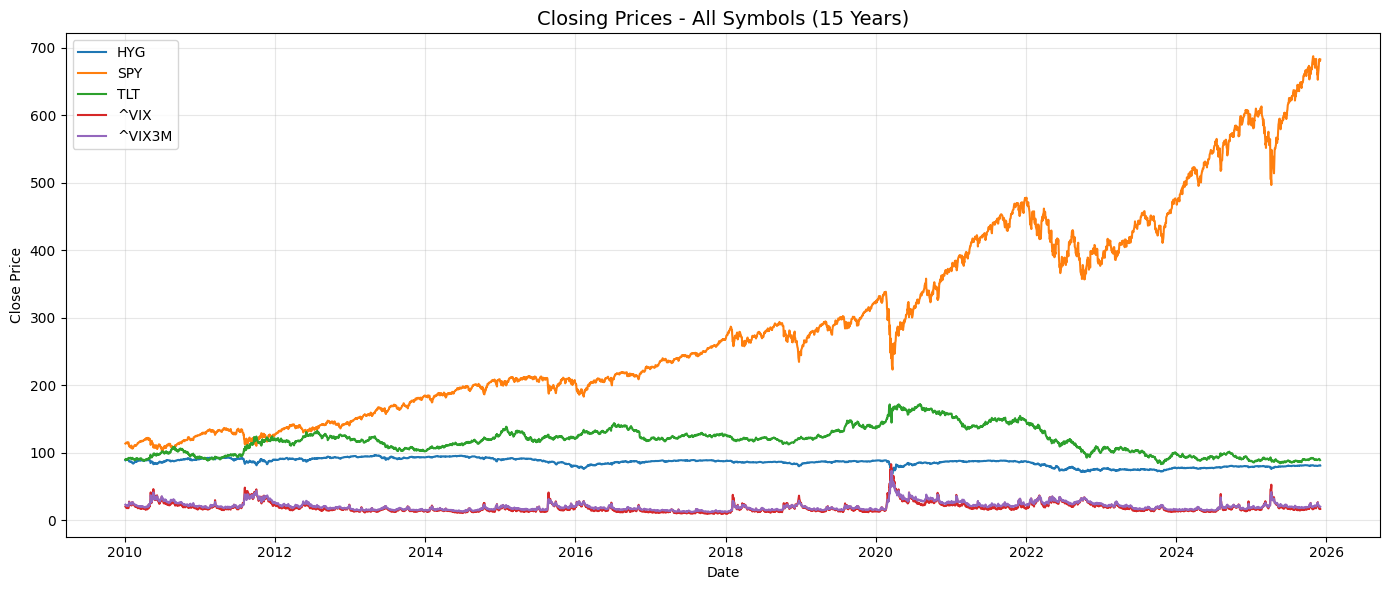

In [27]:
fig, ax = plt.subplots(figsize=(14, 6))

for symbol in raw_df['symbol'].unique():
    data = raw_df[raw_df['symbol'] == symbol]
    ax.plot(data['date'], data['close'], label=symbol, linewidth=1.5)

ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Closing Prices - All Symbols (15 Years)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

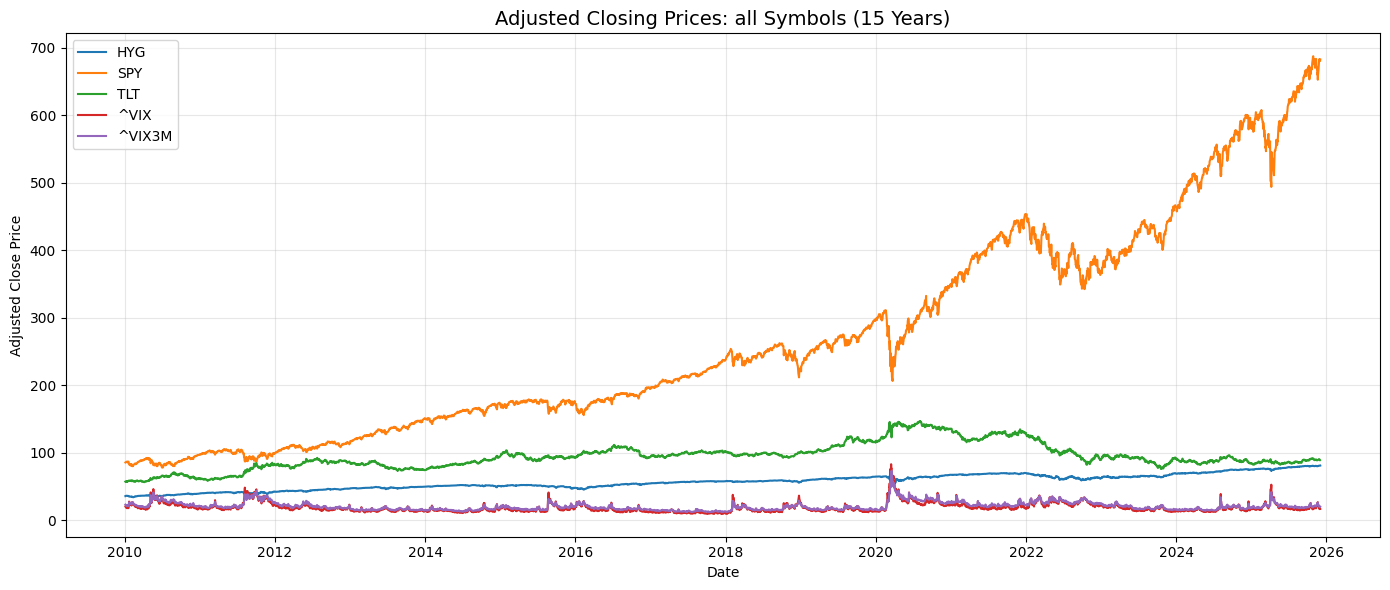

In [28]:
fig, ax = plt.subplots(figsize=(14, 6))

for symbol in curated_df['symbol'].unique():
    data = curated_df[curated_df['symbol'] == symbol]
    ax.plot(data['date'], data['adj_close'], label=symbol, linewidth=1.5)

ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price')
ax.set_title('Adjusted Closing Prices: all Symbols (15 Years)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

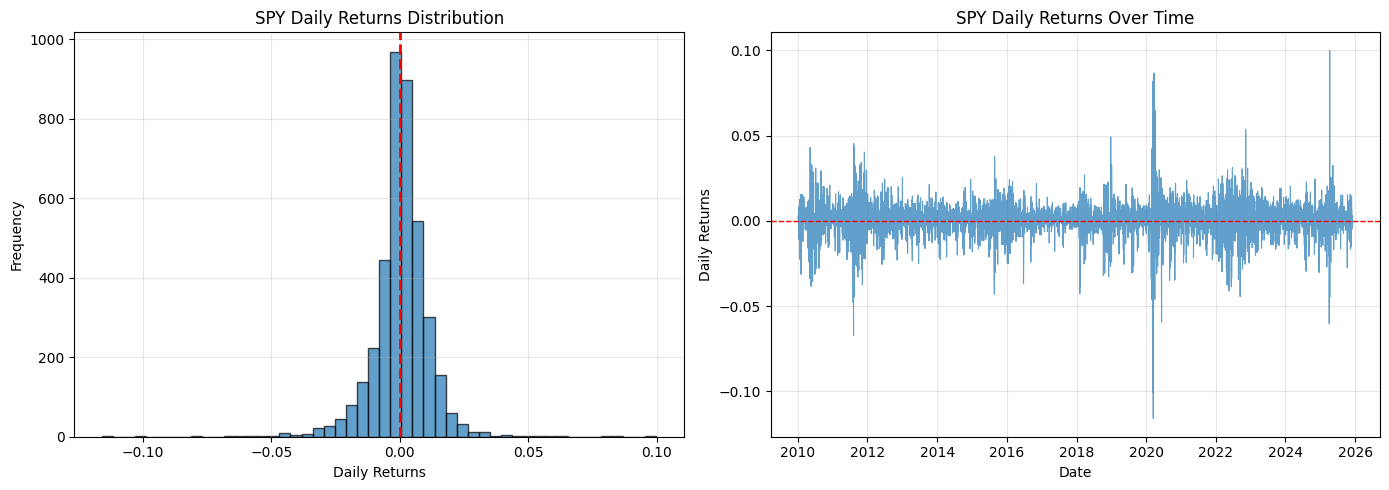


SPY Returns Statistics:
Mean: 0.0005
Std:  0.0109
Min:  -0.1159
Max:  0.0999


In [29]:
# Plot SPY returns distribution
spy_returns = curated_df[curated_df['symbol'] == 'SPY']['ret'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(spy_returns, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Daily Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SPY Daily Returns Distribution')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].grid(alpha=0.3)

# Time series
spy_data = curated_df[curated_df['symbol'] == 'SPY']
axes[1].plot(spy_data['date'], spy_data['ret'], linewidth=0.8, alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Returns')
axes[1].set_title('SPY Daily Returns Over Time')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSPY Returns Statistics:")
print(f"Mean: {spy_returns.mean():.4f}")
print(f"Std:  {spy_returns.std():.4f}")
print(f"Min:  {spy_returns.min():.4f}")
print(f"Max:  {spy_returns.max():.4f}")

In [ ]:
# VIX volatility regimes over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Shows volatility regimes
vix_data = curated_df[curated_df['symbol'] == '^VIX'].sort_values('date')
axes[0].plot(vix_data['date'], vix_data['adj_close'], linewidth=1)
axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX: Volatility Regimes (Low Vol 2017, COVID 2020, Inflation 2022)')
axes[0].grid(alpha=0.3)
axes[0].axhline(20, color='orange', linestyle='--', alpha=0.5, label='Historical Median')
axes[0].legend()

# Distribution of VIX changes shows fat tails
vix_returns = vix_data['ret'].dropna()
axes[1].hist(vix_returns, bins=100, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Daily VIX Returns')
axes[1].set_ylabel('Frequency')
axes[1].set_title('VIX Returns Distribution (Extremely Fat-Tailed)')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"VIX Statistics:")
print(f"Mean:     {vix_returns.mean():.4f}")
print(f"Std:      {vix_returns.std():.4f}")
print(f"Skewness: {vix_returns.skew():.4f}")
print(f"Kurtosis: {vix_returns.kurtosis():.4f} (fat-tailed!)")

In [ ]:
# VIX term structure shows contango vs backwardation
vix_data = curated_df[curated_df['symbol'] == '^VIX'].sort_values('date').set_index('date')
vix3m_data = curated_df[curated_df['symbol'] == '^VIX3M'].sort_values('date').set_index('date')

# Calculate term structure ratio
term_structure = vix3m_data['adj_close'] / vix_data['adj_close']
term_structure = term_structure.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(term_structure.index, term_structure.values, linewidth=1)
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Flat Term Structure')
ax.fill_between(term_structure.index, 1.0, term_structure.values, 
                 where=(term_structure.values > 1.0), alpha=0.3, color='green', label='Contango (Normal)')
ax.fill_between(term_structure.index, 1.0, term_structure.values, 
                 where=(term_structure.values < 1.0), alpha=0.3, color='red', label='Backwardation (Stress)')
ax.set_xlabel('Date')
ax.set_ylabel('VIX3M / VIX Ratio')
ax.set_title('VIX Term Structure: Contango vs Backwardation')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Term Structure Statistics:")
print(f"Mean ratio: {term_structure.mean():.4f}")
print(f"% in Contango: {(term_structure > 1.0).sum() / len(term_structure) * 100:.1f}%")
print(f"% in Backwardation: {(term_structure < 1.0).sum() / len(term_structure) * 100:.1f}%")

In [ ]:
# TLT bond returns and correlation with SPY
tlt_data = curated_df[curated_df['symbol'] == 'TLT'].sort_values('date')
spy_data = curated_df[curated_df['symbol'] == 'SPY'].sort_values('date')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TLT returns distribution
tlt_returns = tlt_data['ret'].dropna()
axes[0].hist(tlt_returns, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Daily Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_title('TLT Returns Distribution')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].grid(alpha=0.3)

# Rolling bond-equity correlation
merged = spy_data[['date', 'ret']].merge(tlt_data[['date', 'ret']], on='date', suffixes=('_spy', '_tlt'))
merged = merged.sort_values('date').set_index('date')
rolling_corr = merged['ret_spy'].rolling(60).corr(merged['ret_tlt'])

axes[1].plot(rolling_corr.index, rolling_corr.values, linewidth=1)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(rolling_corr.index, 0, rolling_corr.values, 
                      where=(rolling_corr.values < 0), alpha=0.3, color='green', label='Risk-Off (Negative)')
axes[1].fill_between(rolling_corr.index, 0, rolling_corr.values, 
                      where=(rolling_corr.values > 0), alpha=0.3, color='red', label='Risk-On (Positive)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('60-Day Rolling Correlation')
axes[1].set_title('SPY-TLT Correlation (Bond-Equity Relationship)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"TLT Statistics:")
print(f"Mean: {tlt_returns.mean():.4f}")
print(f"Std:  {tlt_returns.std():.4f}")
print(f"\nSPY-TLT Correlation: {merged['ret_spy'].corr(merged['ret_tlt']):.4f}")

In [ ]:
# HYG credit risk analysis
hyg_data = curated_df[curated_df['symbol'] == 'HYG'].sort_values('date')
spy_data = curated_df[curated_df['symbol'] == 'SPY'].sort_values('date')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns distribution
hyg_returns = hyg_data['ret'].dropna()
axes[0, 0].hist(hyg_returns, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Daily Returns')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('HYG Returns Distribution')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(alpha=0.3)

# Credit-equity relationship
merged = spy_data[['date', 'ret']].merge(hyg_data[['date', 'ret']], on='date', suffixes=('_spy', '_hyg'))
axes[0, 1].scatter(merged['ret_hyg'], merged['ret_spy'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('HYG Returns')
axes[0, 1].set_ylabel('SPY Returns')
axes[0, 1].set_title('Credit-Equity Relationship')
axes[0, 1].grid(alpha=0.3)

# HYG cumulative returns show drawdowns
hyg_data_indexed = hyg_data.set_index('date')
cumulative_returns = (1 + hyg_data_indexed['ret']).cumprod()
axes[1, 0].plot(cumulative_returns.index, cumulative_returns.values, linewidth=1)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].set_title('HYG Cumulative Returns (Trends into Crises)')
axes[1, 0].grid(alpha=0.3)

# Rolling correlation with SPY
merged_indexed = merged.sort_values('date').set_index('date')
rolling_corr = merged_indexed['ret_spy'].rolling(60).corr(merged_indexed['ret_hyg'])
axes[1, 1].plot(rolling_corr.index, rolling_corr.values, linewidth=1)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('60-Day Rolling Correlation')
axes[1, 1].set_title('SPY-HYG Correlation (Credit Risk)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"HYG Statistics:")
print(f"Mean: {hyg_returns.mean():.4f}")
print(f"Std:  {hyg_returns.std():.4f}")
print(f"\nSPY-HYG Correlation: {merged['ret_spy'].corr(merged['ret_hyg']):.4f}")